# Language identification model 

In this exercise you will fill in the gaps to build a model that takes text as an input an predicts the language.
This notebook will guide you through all steps that have to be performed but expects you to have basic knowledge of TensorFlow. If you are unsure, you can consult the notebook containing an introduction to TensorFlow.
 

### Objectives

* Perform a simple exploration over a text dataset of language identification
* Build a simple neural network for automatic identification of language (english, spanish and german)

### Requirements

For installing all necessar requirements use the language_identification.yml and the following commands   
```
conda env create -f language_identification.yaml   
conda activate language_identification
```  
For installing a kernel for running this notebook create a new ipython kernel within the activated environment
```
python -m ipykernel install --user --name=language_detection
```
  

In [1]:
import sys
import os
import requests

import nltk
import sklearn
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np


nltk.download('stopwords')
nltk.download('punkt')

print(tf.__version__)

2.10.0


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sevi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sevi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data importation

In this step, we will use a dataset of 90k samples consisting of text passages and their corresponding language label. This dataset contains samples from 20 different languages. However for our example we will focus on 3 different languages: English, Spanish and German. [Further information can be found here](https://huggingface.co/datasets/papluca/language-identification)

<mark>Step 1.</mark> Create a directory for your data named ```data```


In [2]:
# Download data and save it into the data folder
DATA_DIRECTORY = "data"

with open(f"{DATA_DIRECTORY}/train.csv", "wb") as f:
    f.write(requests.get("https://huggingface.co/datasets/papluca/language-identification/resolve/main/train.csv").content)

with open(f"{DATA_DIRECTORY}/test.csv", "wb") as f:
    f.write(requests.get("https://huggingface.co/datasets/papluca/language-identification/resolve/main/test.csv").content)

with open(f"{DATA_DIRECTORY}/valid.csv", "wb") as f:
    f.write(requests.get("https://huggingface.co/datasets/papluca/language-identification/resolve/main/valid.csv").content)


<mark>Step 2.</mark> Load the data into a train, validation and testset using pandas


In [3]:
# Load data in pandas for filtering

train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/valid.csv")
test_df = pd.read_csv("data/test.csv") 

<mark>Step 3.</mark> Filter the dataset to contain only data for the languages we are interested in (English, Spanish, German)


In [4]:
# Select only "en", "es" and "de"
lang_list = ["es", "en", "de"]

train_df = train_df.loc[train_df.labels.isin(lang_list)]
val_df = val_df.loc[val_df.labels.isin(lang_list)]
test_df = test_df.loc[test_df.labels.isin(lang_list)]

train_df

labels                                               text
11        es  Un producto de una calidad y capacidad increíb...
15        de  Alles in allem ein super schönes Teil, deshalb...
17        de  Einer Freundin Geschenk da sie Flugbegleiterin...
25        es  El tacto es horrible, el dedo se engancha cuan...
26        es  Casco para decoración. No homologado y poco má...
...      ...                                                ...
69969     en        Received an empty envelope with no stickers
69970     en  Color bleeds. Softness is lost after only one ...
69979     es  Tuve que devolverlos, el auricular izquierdo s...
69992     es                  Muy bueno para gente con alergias
69998     es  Se me rompió uno al sacarlo del cargador. Cali...

[10500 rows x 2 columns]

# Data exploration

In this step, we will perform a simple analysis of some important characteristics of our dataset:

* Word frequency distribution
* Distribution of labels 
* Text passage length distribution

Our corpus consists of 227718 different words.


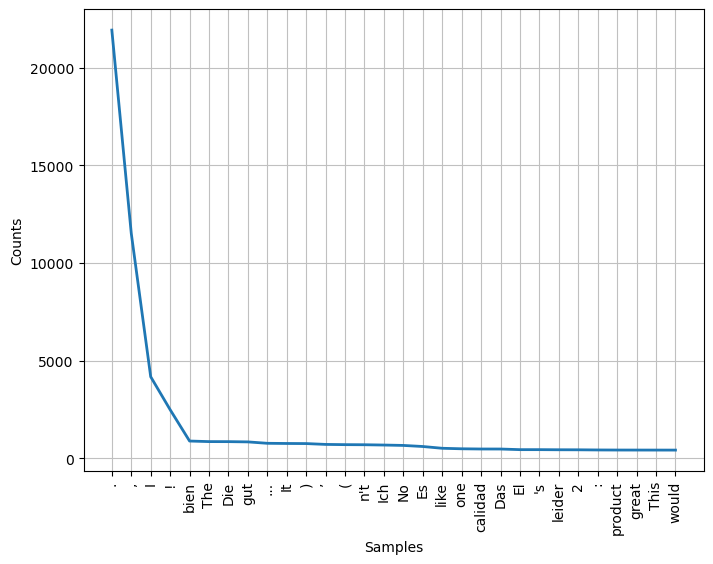

Distribution of labels:


es    3500
de    3500
en    3500
Name: labels, dtype: int64

In [5]:
# We calculate a list of words (tokens) which will be used for evaluate the distribution of
# tokens in the dataset

# We declare a stoplist for the three used languages
stoplist = [nltk.corpus.stopwords.words(lang) for lang in ["english", "spanish", "german"]]
stoplist = set([word for lang_list in stoplist for word in lang_list])

# Now, only for visualization purposes we create a listh with all the tokens
word_list = []
for sentence in train_df["text"].to_list():
    word_list += [word for word in nltk.tokenize.word_tokenize(sentence) if word not in stoplist]

print(f"Our corpus consists of {len(word_list)} different words.")


plt.figure(figsize=(8, 6)) 

fd = nltk.probability.FreqDist(word_list)
fd.plot(30)

print("Distribution of labels:")

train_df.labels.value_counts()

## Exploring the length of the text sequences

Before we define a base architecture in TensorFlow, we must **find a good value for the size of the input** of the model. We evaluate the average size (e.g. number of words/tokens) of each sample of the corpus.

<mark>Step 4.</mark> Generate a `pandas.Series` Object that contains the length of each sentence in terms of tokens.


Average length: 31.605238095238096
Maximum length: 381
Standard deviation length: 29.969598705150613


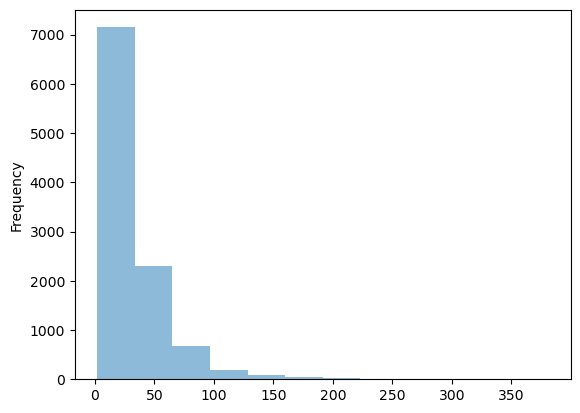

In [6]:
# We then evaluate the size of each sentence in the corpus

splitted_text = train_df['text'].apply(lambda txt: txt.split(' '))
splitted_text_len = splitted_text.apply(lambda x: len(x))
ax = splitted_text_len.plot.hist(bins=12, alpha=0.5)

print("Average length: {}".format(splitted_text_len.mean()))
print("Maximum length: {}".format(splitted_text_len.max()))
print("Standard deviation length: {}".format(splitted_text_len.std()))

We select $50$, as it covers up to 68% of the data (one standard deviation). Sequences longer than $50$ words will be chunked. **This is done for the sake of simplicity** 

# Data preparation
## Using `tf.data` for creating the dataset

`tf.data` is one of the most useful libraries for accessing datasets in TensorFlow. It provides several handlers for reading and creating usable datasets with low memory footprint.


<mark>Step 5.</mark> Use `tf.keras.utils.to_categorical()` and the `sklearn.preprocessing.LabelEncoder.transform` functionality to  transorm the labels into integers (categorical data).
* Build the datasets using `tf.data`
* Transform the text input into sequences of up to 50 integers (vectorization)

In [7]:
# Create dictionary for enconding labels
# This is done using LabelEncoder from scikit-learn
# It's quite useful when the number if classes is high

le = sklearn.preprocessing.LabelEncoder()
le.fit(lang_list)

num_classes = len(le.classes_)

train_labels = tf.keras.utils.to_categorical(le.transform(train_df.pop('labels')), num_classes=num_classes)
val_labels = tf.keras.utils.to_categorical(le.transform(val_df.pop('labels')), num_classes=num_classes)
test_labels = tf.keras.utils.to_categorical(le.transform(test_df.pop('labels')), num_classes=num_classes)

<mark>Step 6.</mark> Build the datasets using `tf.data.Dataset.from_tensor_slices` and pass your X data as a `list` and the, labels that were generated in the prior cell 

In [8]:
raw_train_ds = tf.data.Dataset.from_tensor_slices((train_df["text"].to_list(), train_labels)) # X, y
raw_val_ds = tf.data.Dataset.from_tensor_slices((val_df["text"].to_list(), val_labels))
raw_test_ds = tf.data.Dataset.from_tensor_slices((test_df["text"].to_list(), test_labels))

In [9]:
# Exploring a sample of the corpus this should output a byte string and a Label array with 3 values of which only one is zero.

batch_size = 32
seed = 42

for text, label in raw_train_ds.take(1):
    print("Text: ", text.numpy())
    print("Label:", label.numpy())

Text:  b'Un producto de una calidad y capacidad incre\xc3\xadbles que ser\xc3\xa1 el placer de todo amante de la tecnolog\xc3\xada'
Label: [0. 0. 1.]


At this point, the dataset is still raw, which means, it's still composed of text sequences.

## Preprocessing the dataset using `tf.keras.layers.TextVectorization`

Before the dataset can be fed to the model, the data has to be transformed into a vectorized representation of each text. This means each word will be transformed to an integer value e.g. ("book" --> 45). 

<mark>Step 7.</mark> Use `tf.keras.layers.TextVectorization` to generate a vectorization layer. Use `"lower_and_strip_punctuation"` as standardization and `int` as output mode. 

In [10]:
# Prepare dataset for training

max_features = 10000 # top 10K most frequent words
sequence_length = 50 # Was defined in the previous data exploration section

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# This step is important to perform it only on the training set. The `adapt()` method will learn the vocabulary for our dataset

vectorize_layer.adapt(train_df["text"].to_list()) # vectorize layer is fitted to the training data

The following cell will visualize how the input to the model currently looks like. 

In [11]:
# Helper for visualizing the processed input
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label


# Reviewing how a sample of the corpus will be fed to the model

text_batch, label_batch = next(iter(raw_train_ds.batch(64)))
first_review, first_label = text_batch[0], label_batch[0]
print("First text: ", first_review)
print("Language (label)", le.inverse_transform([np.argmax(first_label)]))
print("Vectorized text", vectorize_text(first_review, first_label))

First text:  tf.Tensor(b'Un producto de una calidad y capacidad incre\xc3\xadbles que ser\xc3\xa1 el placer de todo amante de la tecnolog\xc3\xada', shape=(), dtype=string)
Language (label) ['es']
Vectorized text (<tf.Tensor: shape=(1, 50), dtype=int64, numpy=
array([[  39,  112,    5,   61,   85,   11, 2033,    1,    7, 2603,   16,
           1,    5,  162,    1,    5,   13, 7611,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]], dtype=int64)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 1.], dtype=float32)>)


<mark>Step 8.</mark> Create the final datasets using the vectorize layer. Use the `.map` function on the raw datasets, and return the vectorized text and corresponding y value. 

In [12]:
# Create the final datasets using the vectorize_layer



train_ds = raw_train_ds.map(lambda x, y: (vectorize_layer(x), y)) # returns vectorize_layer(text), label
val_ds = raw_val_ds.map(lambda x, y: (vectorize_layer(x), y))
test_ds = raw_test_ds.map(lambda x, y: (vectorize_layer(x), y))

print(val_ds) 

<MapDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(3,), dtype=tf.float32, name=None))>


In [13]:
# Applying cache techniques for improving inference and training time
# It allows tensorflow to prepare the data while it trains the model

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.batch(batch_size=batch_size)
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.batch(batch_size=batch_size)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.batch(batch_size=batch_size)
test_ds = test_ds.prefetch(AUTOTUNE)



# Model training and specification

<mark>Step 9.</mark> Define the following architecture using `tf.keras.Sequential`:
1. `tf.keras.layers.Embedding` layer for building a more dense and compact representation for each of the top 10.000 most frequent words. Use the maximal number of features + 1 and 16 as the input and output dimensions.
2. `tf.keras.layers.Dropout` layer for improving regularization, use a dropout rate of 0.2
3. `tf.keras.layers.GlobalAveragePooling1D` for returning a fixed-length ouput vector for each example. It averages over the sequence dimension, allowing the model to handle variable size inputs (less than 50) in a simple way.
4. `tf.keras.layers.Dense` layer for the logits of each class (es, en, de)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 3)                 51        
                                                                 
Total params: 160,067
Trainable params: 160,067
Non-trainable params: 0
__________________________________________________

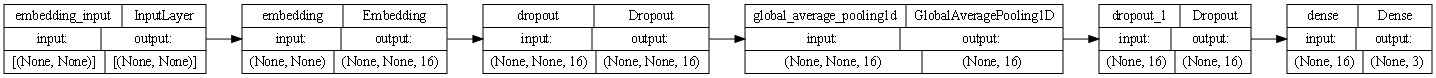

In [14]:
# Model training

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features + 1, 16),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3)])

model.summary()
tf.keras.utils.plot_model(model=model , rankdir="LR", dpi=72, show_shapes=True)



<mark>Step 10.</mark> Compile the model using the following settings:
* `tf.keras.losses.CategoricalCrossentropy` with 0.1 for label smoothing
* Adam as optimizer
* Accuracy as metric


In [15]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
              optimizer='adam',
              metrics=['accuracy'])


<mark>Step 11.</mark> Train the model for 10 epochs


In [16]:
# Train

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10)

Epoch 1/10
329/329 [==============================] - 9s 26ms/step - loss: 0.8787 - accuracy: 0.8850 - val_loss: 0.6197 - val_accuracy: 0.9927
Epoch 2/10
329/329 [==============================] - 9s 26ms/step - loss: 0.5177 - accuracy: 0.9936 - val_loss: 0.4499 - val_accuracy: 0.9980
Epoch 3/10
329/329 [==============================] - 11s 33ms/step - loss: 0.4397 - accuracy: 0.9985 - val_loss: 0.4235 - val_accuracy: 0.9980
Epoch 4/10
329/329 [==============================] - 14s 42ms/step - loss: 0.4251 - accuracy: 0.9990 - val_loss: 0.4167 - val_accuracy: 0.9993
Epoch 5/10
329/329 [==============================] - 20s 60ms/step - loss: 0.4173 - accuracy: 0.9993 - val_loss: 0.4124 - val_accuracy: 0.9993
Epoch 6/10
329/329 [==============================] - 17s 52ms/step - loss: 0.4118 - accuracy: 0.9992 - val_loss: 0.4085 - val_accuracy: 0.9993
Epoch 7/10
329/329 [==============================] - 18s 56ms/step - loss: 0.4065 - accuracy: 0.9994 - val_loss: 0.4050 - val_accuracy: 0

# Model evaluation


<mark>Step 12.</mark> Evaluate the model on the test set


In [17]:
# Evaluate the model

loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

47/47 [==============================] - 2s 37ms/step - loss: 0.3977 - accuracy: 0.9993
Loss:  0.3976571559906006
Accuracy:  0.9993333220481873


Keys of the history variable
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


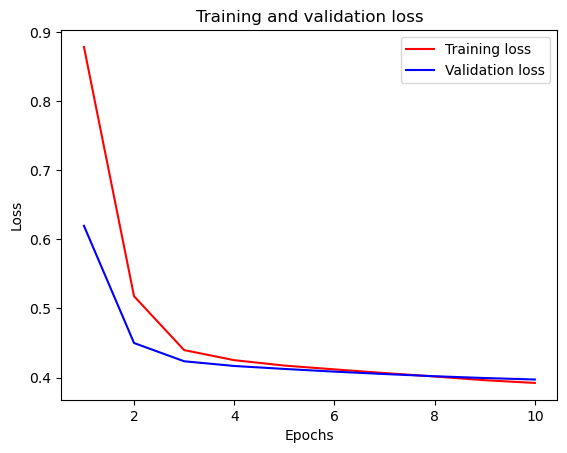

In [18]:
# Plot loss 
history_dict = history.history
print("Keys of the history variable")
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


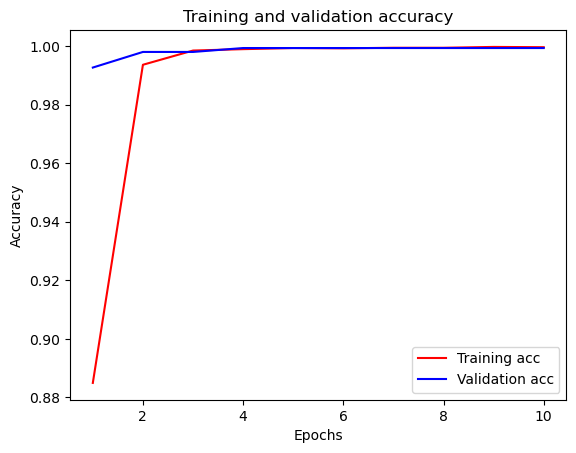

In [19]:
# Plot accuracy

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

<mark>Step 13.</mark> Fill in the softmax function

In [20]:
def softmax(x):
    """x is a numpy array where each row corresponds to the scores (outputs) of the model, 
        e.g.: [[0.2, 0.6, 0.7], [0.1, 0.5, 0.4]]
        Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

### Predict on unseen data
<mark>Step 14.</mark> Use the vectorize layer to prepare your inputs.

In [21]:

examples = [
  "Esto me pareció increíble",
  "I think it was incredible.",
  "Ich finde es war unglaublich"
]

examples_vectorized = vectorize_layer(examples)


<mark>Step 15.</mark> Use your model to predict the logits of the vectorized examples

In [22]:
logits = model.predict(examples_vectorized)
probits = softmax(logits)
idx_predictions = np.argmax(probits, axis=1)
print("Probabilities: {}".format(np.max(probits, axis=1)))
print("Corresponding classes: {}".format(le.inverse_transform(idx_predictions)))

1/1 [==============================] - 0s 407ms/step
Probabilities: [0.40231505 0.4562141  0.4118683 ]
Corresponding classes: ['es' 'en' 'de']


<mark>Step 16.</mark> Create a directory called `saved_model` and save the model using `.save()`

In [23]:
model.save('saved_model/simple_mlp_novectorize.h5')

The next cell stores the vectorize layer in a directory called "vectorizer". As TF yet does not support saving TextVectorizer objects, we save and load it as a layer of tf.keras.Sequential


In [24]:

def store_text_vectorizer(vectorizer, file_path: str):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
    model.add(vectorizer)
    model.save(file_path)

store_text_vectorizer(vectorize_layer, "vectorizer")


INFO:tensorflow:Assets written to: vectorizer\assets


<mark>Step 17.</mark> Load the vectorize layer and model. You can load the vectorize layer by loading it as a `tf.model` and then access the first layer using `.layers[0]`

In [25]:
# Load the model
saved_model = tf.keras.models.load_model('saved_model/simple_mlp_novectorize.h5')
vectorize_layer = tf.keras.models.load_model('vectorizer').layers[0]

new_examples = ["I made it to task 3.", "Ich hab es bis task 3 geschafft."]

new_examples_vectorized = vectorize_layer(new_examples)
logits = saved_model.predict(new_examples_vectorized)

probabilities = softmax(logits)
print(probabilities)
for label, text in zip(probabilities, new_examples):
    print(text, le.inverse_transform([np.argmax(label)]))

1/1 [==============================] - 0s 65ms/step
[[0.37827188 0.6469698  0.46437022]
 [0.6217282  0.35303017 0.5356298 ]]
I made it to task 3. ['en']
Ich hab es bis task 3 geschafft. ['de']
